In [ ]:
#hide
import matplotlib.pyplot as plt
import numpy as np

# qsam - quantum protocol sampling

> Efficient and user-friendly sampling of quantum protocols.

## Install

`pip install qsam`... not yet, soon to come

## How to use

Consider the *Repeat-until-success* protocol to prepare the GHZ state $|GHZ\rangle=\frac{1}{\sqrt{2}}(|0000\rangle+|1111\rangle)$ on qubits 0-3. Qubit 4 is a ancillary flag qubit which we measure as `0` if the preparation was successful, i.e. the GHZ-state has been prepared upto max. 1 error and `1` if the preparation was unsuccessful, i.e. the output state is erroneous by an error weight larger than 1. In this case we want to repeat the preparation for a maximium of 3 times. If for the 3rd iteration we measure again a `1` we want to count a **logical error**. The circuit looks like this:

In [ ]:
from qsam.circuit import Circuit

ghz = Circuit([ {"init": {0,1,2,3,4}},
                {"H": {0}},
                {"CNOT": {(0,1)}},
                {"CNOT": {(1,2)}},
                {"CNOT": {(2,3)}},
                {"CNOT": {(3,4)}},
                {"CNOT": {(0,4)}},
                {"measure": {4}}   ])

Now we define the protocol. **EXIT** marks a *significant* protocol termination which we would like to count as a logical failure. If we measure the flag as `0` for some intermediate circuit the protocol terminates *insignificantly* which we don't want to track. The **START** node must always be given and must always have a transition with `check=True` to *only a single node*. For the other nodes we can reference any prospective measurement result in the complete measurement history of the *current* protocol iteration by using the node name in backticks, for example `` `ghz1` `` will be replaced with the measurement result of the execution of the circuit associated with node ghz1. If a measurement at a certain point is not in the past of a node the part of the check expression containing this reference will automatically evaluate to `False`. Here is how we define the *Repeat-until-success* protocol.

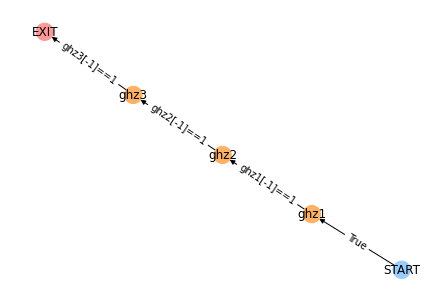

In [ ]:
from qsam.protocol import Protocol,draw_protocol

ghz3 = Protocol()
ghz3.add_nodes_from(['ghz1','ghz2','ghz3'], circuits=ghz)

ghz3.add_edge('START', 'ghz1', check='True')
ghz3.add_edge('ghz1', 'ghz2', check='ghz1[-1]==1')
ghz3.add_edge('ghz2', 'ghz3', check='ghz2[-1]==1')
ghz3.add_edge('ghz3', 'EXIT', check='ghz3[-1]==1')

draw_protocol(ghz3)

Now, we are ready to sample. Let's define some error parameters, instantiate a `Sampler` object and start sampling.

In [ ]:
sample_range = np.logspace(-3,0,10)
err_params = {'p1': 1, 'p2': 0.5}

In [ ]:
#slow
from qsam.samplers import Sampler
from qsam.simulators.chp import CHP

sam = Sampler(ghz3, CHP)
p_L, std = sam.run(1000, sample_range, err_params)

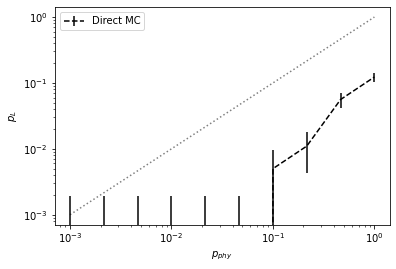

In [ ]:
#hide_input
#slow

plt.errorbar(sample_range, p_L, fmt='--', c="black", yerr=std, label="Direct MC")
plt.plot(sample_range, sample_range, 'k:', alpha=0.5)
plt.xlabel('$p_{phy}$')
plt.ylabel('$p_L$')
plt.xscale('log')
plt.yscale('log')
plt.legend();

We can see that for large physical error rates the direct sampler performs good but gets worse for lower rates. In this region we benefit a lot by using the subset sampler. The only extra thing we need to specify is the weight cutoff per partition (which is used for equally for each circuit in the protocol). We can immediately see the benefit of subset sampling at low error rates:

**UNDER CONSTRUCTION, PLEASE DON'T USE SUBSET SAMPLER AT THE MOMENT.**

In [ ]:
#slow
from qsam.samplers import SubsetSampler

sam = SubsetSampler(ghz3, err_params)
p_L_up, p_L_low, ss_std = sam.run(n_samples=1000, w_max=[1,3])

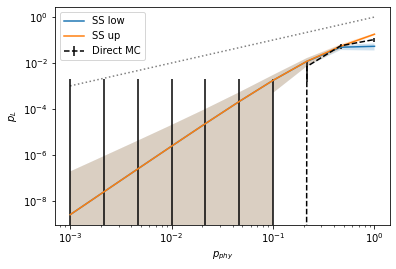

In [ ]:
#hide_input
#slow

plt.errorbar(p1, p_L, fmt='--', c="black", yerr=std, label="Direct MC")

plt.plot(p1, p_L_low, label="SS low")
plt.fill_between(p1, p_L_low-ss_std, p_L_low+ss_std, alpha=0.2)
plt.plot(p1, p_L_up, label="SS up")
plt.fill_between(p1, p_L_up-ss_std, p_L_up+ss_std, alpha=0.2)

plt.plot(p1, p1, 'k:', alpha=0.5)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$p_{phy}$')
plt.ylabel('$p_L$')
plt.legend();